# Softmax Application

In [1]:
# !pip install forgebox

In [2]:
from forgebox.imports import *

In [3]:
HOME = os.environ["HOME"]

In [4]:
DATA = Path(HOME)/"data"
TRAIN = DATA/"train.csv"
TEST = DATA/"test.csv"
SAMP = DATA/"sample_submission.csv"

In [5]:
train_df = pd.read_csv(TRAIN)
test_df = pd.read_csv(TEST)
samp_df = pd.read_csv(SAMP)

In [6]:
@interact
def preview_data(path = [TRAIN,TEST,SAMP]):
    display(pd.read_csv(path))

interactive(children=(Dropdown(description='path', options=(PosixPath('/Users/salvor/data/train.csv'), PosixPa…

In [7]:
yct = pd.DataFrame(train_df.type.value_counts())
yct

,type
Ghoul,129
Goblin,125
Ghost,117


In [8]:
y2i = dict(zip(yct.index,range(len(yct))))
i2y = dict(zip(range(len(yct)),yct.index))
y2i,i2y

({'Ghoul': 0, 'Goblin': 1, 'Ghost': 2}, {0: 'Ghoul', 1: 'Goblin', 2: 'Ghost'})

In [9]:
colorct = pd.DataFrame(train_df.color.value_counts())
colorct

,color
white,137
clear,120
green,42
black,41
blue,19
blood,12


In [10]:
color2i = dict(zip(colorct.index,range(len(colorct))))
i2color = dict(zip(range(len(colorct)),colorct.index))
color2i,i2color

({'white': 0, 'clear': 1, 'green': 2, 'black': 3, 'blue': 4, 'blood': 5},
 {0: 'white', 1: 'clear', 2: 'green', 3: 'black', 4: 'blue', 5: 'blood'})

In [11]:
def reset(df):return df.reset_index().drop("index",axis=1)

train_df = reset(train_df.sample(frac=1.))

In [12]:
def train_val_split(df,ratio = .8):
    split = (np.random.rand(len(df))<ratio)
    return reset(df[split]),reset(df[~split])

In [13]:
tdf,vdf = train_val_split(train_df)

In [14]:
display(tdf)
display(vdf)

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,674,0.613365,0.489438,0.580808,0.599846,white,Ghoul
1,429,0.453214,0.475223,0.558776,0.230523,black,Goblin
2,366,0.321530,0.456823,0.320145,0.415155,white,Ghost
3,286,0.273458,0.463239,0.453515,0.336390,white,Goblin
4,93,0.481716,0.527251,0.740270,0.700857,blood,Ghoul
...,...,...,...,...,...,...,...
291,669,0.515397,0.561786,0.528818,0.373502,white,Ghoul
292,637,0.209997,0.497112,0.642451,0.327212,blue,Goblin
293,515,0.227948,0.501056,0.471120,0.698965,white,Goblin
294,721,0.173607,0.589613,0.363439,0.614158,white,Ghost


,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,627,0.586227,0.464284,0.599774,0.856757,blue,Ghoul
1,662,0.403727,0.364366,0.609004,0.487301,white,Goblin
2,118,0.304302,0.463015,0.385387,0.219313,clear,Ghost
3,176,0.501306,0.536995,0.631199,0.591106,clear,Ghoul
4,287,0.339501,0.336981,0.492441,0.345592,white,Goblin
...,...,...,...,...,...,...,...
70,653,0.503780,0.929440,0.366461,0.401567,blue,Ghost
71,199,0.197071,0.455686,0.451490,0.417516,clear,Ghost
72,226,0.207874,0.545294,0.357987,0.484055,clear,Ghost
73,329,0.379548,0.336620,0.513244,0.371015,white,Goblin


In [15]:
def get_x(df):
    color_idx = df.color.apply(lambda x:color2i[x]).values
    color_oh = np.eye(len(color2i))[color_idx]
    return np.concatenate([df[["bone_length","rotting_flesh","hair_length","has_soul"]].values,
                         color_oh],axis=1)

plot 20 rows of input

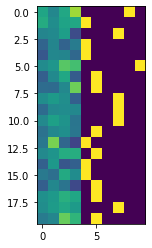

In [16]:
try_x=get_x(train_df)[:20]
plt.imshow(try_x)

In [17]:
def get_y(df):
#     return np.eye(len(y2i))[df.type.apply(lambda x:y2i[x]).values]
    return df.type.apply(lambda x:y2i[x]).values

In [18]:
try_y = get_y(train_df)[:20]
# plt.imshow(try_y)

In [19]:
import math
def chunkify(x,bs=64):
    return list(x[i*bs:(i+1)*bs] for i in range(math.ceil(len(x)/bs)))

In [20]:
TF = torch.FloatTensor
TL = torch.LongTensor

In [21]:
class NN(nn.Module):
    def __init__(self,in_ = try_x.shape[1],
                 out_ = yct.__len__(),
                 hs=64):
        super().__init__()
        self.mlp = nn.Sequential(*[
            nn.Linear(in_,hs,bias=False),
            nn.BatchNorm1d(hs),
            nn.ReLU(),
            nn.Linear(hs,hs,bias=False),
            nn.BatchNorm1d(hs),
            nn.ReLU(),
            nn.Linear(hs,out_),
        ])
        
    def forward(self,x):
        return self.mlp(x)

In [22]:
from torch import optim
crit = nn.CrossEntropyLoss()

From the loss function doc

* This criterion combines :func:`nn.LogSoftmax` and :func:`nn.NLLLoss` in one single class.

$\text{loss}(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_j \exp(x[j])}\right)
                   = -x[class] + \log\left(\sum_j \exp(x[j])\right)$
                   
* So the crossEntropyLoss contains the softmax already
But we can use softmax in the accuracy calculation (but we don't have to, the argmax returns the biggest one anyway)

In [23]:
def init_every():
    model = NN()
    opt = optim.Adam(model.parameters())
    return model,opt

In [24]:
model,opt = init_every()
model,opt

(NN(
   (mlp): Sequential(
     (0): Linear(in_features=10, out_features=64, bias=False)
     (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Linear(in_features=64, out_features=64, bias=False)
     (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU()
     (6): Linear(in_features=64, out_features=3, bias=True)
   )
 ), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [25]:
import torch

In [28]:
softmax = nn.Softmax(-1)

In [29]:
def accuracy(y_,y):
    return (softmax(y_).detach().argmax(-1)==y).float().mean()

In [30]:
def train_step(model,opt,x,y):
    opt.zero_grad()
    y_ = model(x)
    loss = crit(y_,y)
    loss.backward()
    opt.step()
    return dict(data_len = x.size(0),
                loss =loss.item(),
                acc = accuracy(y_,y).item())

def eval_step(model,x,y,):
    with torch.no_grad():
        y_ = model(x)
        loss = crit(y_,y)
        return dict(data_len = x.size(0),
                    loss =loss.item(),
                    acc = accuracy(y_,y).item())

In [31]:
def train_epoch(model,opt,train_df):
    model = model.train()
    result = []
    for df in chunkify(train_df):
        x,y = TF(get_x(df)),TL(get_y(df))
        rt = train_step(model,opt,x,y)
        result.append(rt)
    return pd.DataFrame(result)
        
def val_epoch(model,valid_df):
#     model = model.eval()
    result = []
    for df in chunkify(valid_df):
        x,y = TF(get_x(df)),TL(get_y(df))
        rt = eval_step(model,x,y)
        result.append(rt)
    return pd.DataFrame(result)

In [32]:
result = dict()

from tqdm.notebook import tqdm

In [33]:
model,opt = init_every()

for epoch in tqdm(range(30)): 
    result[f"{epoch}_train"] = train_epoch(model,opt,tdf)
    result[f"{epoch}_val"] = val_epoch(model,vdf)

In [34]:
def calc_mean(metric_df):
    loss = (metric_df["loss"].values* metric_df.data_len.values).sum()/metric_df.data_len.sum()
    acc = (metric_df["acc"].values* metric_df.data_len.values).sum()/metric_df.data_len.sum()
    return dict(loss = loss,acc = acc)

In [35]:
metric = pd.DataFrame(list(dict(tag = i,**calc_mean(d)) for i,d in result.items()))
metric

,tag,loss,acc
0,0_train,1.119335,0.314189
1,0_val,0.973328,0.466667
2,1_train,0.945700,0.452703
3,1_val,0.876274,0.653333
4,2_train,0.836284,0.652027
5,2_val,0.809245,0.720000
6,3_train,0.763284,0.719595
7,3_val,0.757341,0.720000
8,4_train,0.710102,0.750000
9,4_val,0.715049,0.733333


Loss


    best loss on epoch end:
    train:	29,
    valid:	17
    


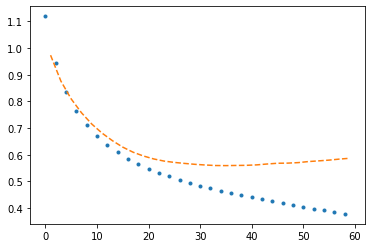

In [43]:
def plot_loss(metric):
    train = metric[metric.tag.str.contains("train")]
    valid = metric[metric.tag.str.contains("val")]
    
    print(f"""
    best loss on epoch end:
    train:\t{train.loss.values.argmin()},
    valid:\t{valid.loss.values.argmin()}
    """)
    
    plt.plot(train.loss,".",valid.loss,"--")
    
def plot_acc(metric):
    train = metric[metric.tag.str.contains("train")]
    valid = metric[metric.tag.str.contains("val")]
          
    print(f"""
    best accuracy on epoch end:
    train:\t{train.acc.values.argmax()},
    valid:\t{valid.acc.values.argmax()}
    """)
    
    plt.plot(train.acc,".",valid.acc,"--")
    
plot_loss(metric)

Accuracy


    best accuracy on epoch end:
    train:	29,
    valid:	18
    


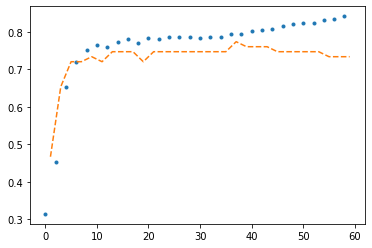

In [44]:
plot_acc(metric)